In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
import gudhi.representations
import os
from datetime import datetime
import matplotlib.dates as mdates

In [3]:

def preprocess_snow_data(folder_path):
    all_data = []

    # Get all CSV files in the folder
    file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

    for file_path in file_paths:
        # Read the first few rows to extract the year
        with open(file_path, 'r') as file:
            first_row = file.readlines()[0]  # Get the first row
            year_month = first_row.split(',')[1].strip()  # Extract the month-year string
            year = year_month.split(' ')[1]  # Split and take the year part

        # Load the actual data, skipping the metadata rows
        df = pd.read_csv(file_path, skiprows=4)

        # Identify date columns by removing metadata-related columns
        meta_cols = ["GHCN ID", "Station Name", "County", "State", "Elevation", "Latitude", "Longitude"]
        date_cols = [col for col in df.columns if col not in meta_cols]

        # Melt the dataframe to long format, keeping only date columns
        df_long = df.melt(id_vars=["County"], value_vars=date_cols, var_name="date", value_name="snow_depth")

        # Add the year to the 'date' column
        df_long['date'] = df_long['date'] + ' ' + year  # Append the extracted year to the date

        # Replace 'M' with NaN and 'T' (trace amounts) with 0.01
        df_long["snow_depth"] = df_long["snow_depth"].replace({"M": None, "T": 0.01}).astype(float)

        # Append to the list
        all_data.append(df_long)

    # Concatenate all files
    clean_data = pd.concat(all_data, ignore_index=True)

    # Convert 'date' to datetime
    clean_data['date'] = pd.to_datetime(clean_data['date'], format='%b %d %Y')

    return clean_data

# Example: preprocess data from a folder
folder_path = '.\data'
cleaned_snow_data = preprocess_snow_data(folder_path)
cleaned_snow_data.head()


,County,date,snow_depth
0,STILLWATER,2015-05-01,0.0
1,MINERAL,2015-05-01,0.0
2,CARTER,2015-05-01,0.0
3,MADISON,2015-05-01,0.0
4,DEERLODGE,2015-05-01,0.0


In [4]:
def aggregate_snow_data(snow_data, county_areas):
    
    # Step 1: Average sensor readings per county per day
    county_avg_snow = snow_data.groupby(["date", "County"])["snow_depth"].mean().reset_index()

    # Step 2: Merge with county area data
    county_avg_snow = county_avg_snow.merge(county_areas, on="County", how="left")

    # Step 3: Compute the weighted average snow depth for the state
    county_avg_snow["weighted_snow"] = county_avg_snow["snow_depth"] * county_avg_snow["AREA"]
    
    # Compute the state-wide weighted average per day
    state_snow = county_avg_snow.groupby("date").apply(
        lambda x: x["weighted_snow"].sum() / x["AREA"].sum()
    ).reset_index(name="state_avg_snow")
    
    # Ensure the result is in DataFrame format
    return state_snow

# Load county area data
county_areas_df = pd.read_csv("MTcounties.csv")

# Example usage (assuming cleaned data is ready)
aggregated_snow_data = aggregate_snow_data(cleaned_snow_data, county_areas_df)
aggregated_snow_data = aggregated_snow_data.sort_values(by="date")

# Print or work with the DataFrame
print(aggregated_snow_data)


           date  state_avg_snow
0    2015-01-01        0.000386
1    2015-01-02        0.175324
2    2015-01-03        1.424501
3    2015-01-04        1.132926
4    2015-01-05        2.866150
...         ...             ...
3679 2025-01-27        0.000000
3680 2025-01-28        0.000000
3681 2025-01-29        0.000042
3682 2025-01-30        0.018836
3683 2025-01-31        0.036596

[3684 rows x 2 columns]


In [5]:
aggregated_snow_data['state_avg_snow'].min()

0.0

In [6]:
time_series = aggregated_snow_data[:365*2]['state_avg_snow'].values

In [7]:
embedding_dim = 3
time_delay =  1

def time_delay_embedding(series, dim, tau):
    n_points = len(series) - (dim - 1) * tau
    return np.array([series[i : i + (dim -1) * tau + 1 : tau] for i in range(n_points)])

point_cloud = time_delay_embedding(time_series, embedding_dim, time_delay)



In [8]:
complex = gd.RipsComplex(points = point_cloud, max_edge_length= (time_series.max() - time_series.min()))
simplex_tree = complex.create_simplex_tree(max_dimension=2)

In [9]:
diag = simplex_tree.persistence()

c:\Users\jbsri\anaconda3\Lib\site-packages\gudhi\persistence_graphical_tools.py:117: UserWarning: usetex mode requires ghostscript.
  warnings.warn("usetex mode requires ghostscript.")


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

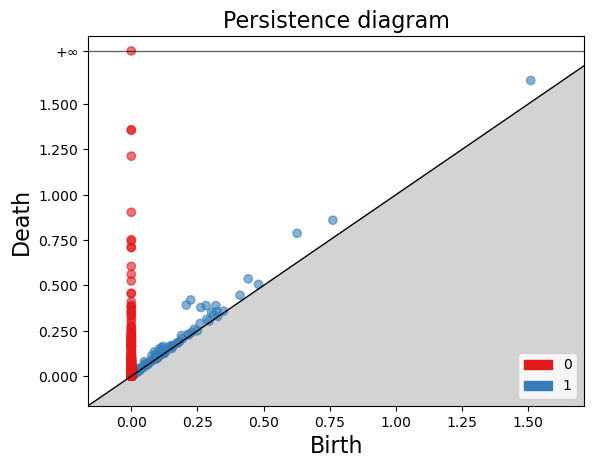

In [10]:
gd.plot_persistence_diagram(diag)

<Axes: title={'center': 'Persistence barcode'}>

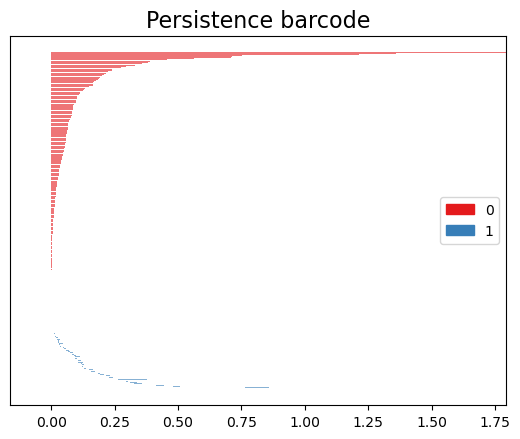

In [11]:
gd.plot_persistence_barcode(diag)

Some thoughts:


1. Need more computing power to run the entire point cloud at once. Maybe I should use a different type of complex?
2. Clearly there is some cyclical nature to the data. Can this be used to predict yearly snow onset?
3. Anomaly detection/analysis ? Some of the later years in Montana (last year, for example) had way less snow than usual overall
4. Next steps?